In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from PIL import Image
import IPython.display as display

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Loading

In [4]:
#Load dataset
cars=pd.read_csv("data/vehicles.csv")

In [5]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [6]:
cars.head(5)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


# Data Preprocessing
## Drop columns

Upon analyzing the dataset, found id, VIN, region, cylinders columns has little to no significance in determining car price. So they can be dropped from the dataset. Also dropping location information like state, region since we are going to come up generic model instead of location specific.

In [9]:
#Drop columns from the dataset
cars_df = cars.drop(columns=["VIN","id","region","cylinders","model","state","odometer"])

## Drop na values

In [11]:
# Drop null entries from the data based on colum "year","manufacturer","odometer","transmission","fuel","model" columns
cars_df = cars_df.dropna(subset=["year","manufacturer","transmission","fuel"])

In [12]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 404996 entries, 27 to 426879
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         404996 non-null  int64  
 1   year          404996 non-null  float64
 2   manufacturer  404996 non-null  object 
 3   condition     241916 non-null  object 
 4   fuel          404996 non-null  object 
 5   title_status  398229 non-null  object 
 6   transmission  404996 non-null  object 
 7   drive         283552 non-null  object 
 8   size          115066 non-null  object 
 9   type          319492 non-null  object 
 10  paint_color   282446 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 37.1+ MB


In [13]:
cars_df.head(5)

,price,year,manufacturer,condition,fuel,title_status,transmission,drive,size,type,paint_color
27,33590,2014.0,gmc,good,gas,clean,other,NaN,NaN,pickup,white
28,22590,2010.0,chevrolet,good,gas,clean,other,NaN,NaN,pickup,blue
29,39590,2020.0,chevrolet,good,gas,clean,other,NaN,NaN,pickup,red
30,30990,2017.0,toyota,good,gas,clean,other,NaN,NaN,pickup,red
31,15000,2013.0,ford,excellent,gas,clean,automatic,rwd,full-size,truck,black


In [14]:
#Feature with null entries
cars_df.isna().sum()

price                0
year                 0
manufacturer         0
condition       163080
fuel                 0
title_status      6767
transmission         0
drive           121444
size            289930
type             85504
paint_color     122550
dtype: int64

## Handle Price outliers

Price columns has a wide spread of data including 0, less than 1000 and extreme values. So below optimizations.
1. Consider entries where price is greater than 1000
2. To handle extreme outliners, consider entries which are within 3 time STD

In [17]:
#Consider entries where price is greater than 1000
cars_df = cars_df.query("price > 1000 ")

In [18]:
#consider entries which are within 3 time STD, run this twice to bring max price under 200k
cars_df = cars_df[np.abs(stats.zscore(cars_df["price"])) <3]
cars_df = cars_df[np.abs(stats.zscore(cars_df["price"])) <3]

## Custom Handle missing values

### Title Status
This is a categorial column. After going over the distinct values found titles like salvage, missing, parts only aren't something customer willing to buy and they also form a very small subset. So consider only clean, rebuilt, lien title status. 

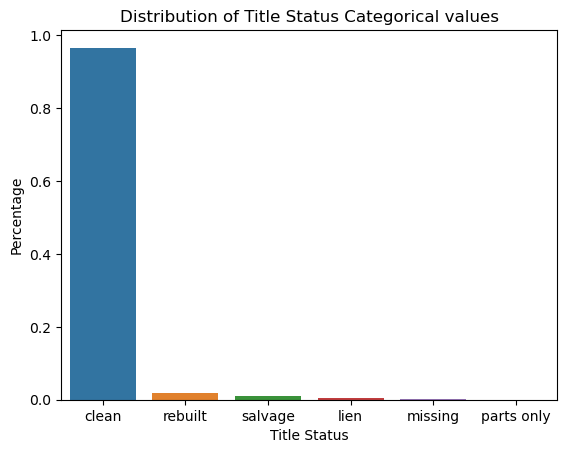

In [20]:
#Visualization for Categorical value distribution
ts_categories = pd.DataFrame(cars_df["title_status"].value_counts()/cars_df["title_status"].count()).reset_index()
fig = sns.barplot(data=ts_categories, x="title_status", y="count")
plt.title("Distribution of Title Status Categorical values")
plt.xlabel("Title Status")
plt.ylabel("Percentage")
plt.show()

In [21]:
#consider only clean, rebuilt, lien title status.
valid_title = ['clean','rebuilt','lien']
cars_df = cars_df.query("title_status in @valid_title")

### Size
This is a categorial column. Fill up NaN Values of random choice using their original probability.

In [23]:
# Find existing distribution of "size" categorical values
size_prob = pd.DataFrame(cars_df["size"].value_counts()/cars_df["size"].count()).reset_index()

#Function to fill null values for for paint_color column
def replaceSizeNaN(row):
    if pd.isna(row["size"]):
        return np.random.choice(size_prob["size"].tolist(), p=size_prob["count"].tolist())

    return row["size"]

#Apply the function to fill na values
cars_df["size"] = cars_df.apply(replaceSizeNaN, axis=1)   

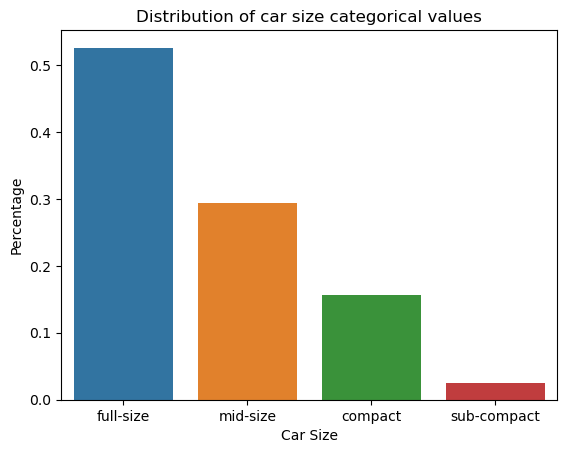

In [24]:
#Visualization for Categorical value distribution
size_df = pd.DataFrame(cars_df["size"].value_counts()/cars_df["size"].count()).reset_index()
fig = sns.barplot(data=size_df, x="size", y="count")
plt.title("Distribution of car size categorical values")
plt.xlabel("Car Size")
plt.ylabel("Percentage")
plt.show()

### Paint Color
This is a categorial column. Fill up NaN Values of random choice using their original probability.

In [26]:

# Find existing distribution of "paint_color" categorical values
pc_df=pd.DataFrame(cars_df["paint_color"].value_counts()/cars_df["paint_color"].count()).reset_index()

#Function to fill null values for for paint_color column
def replacePaintNaN(row):
    if pd.isna(row["paint_color"]):
        return np.random.choice(pc_df["paint_color"].tolist(), p=pc_df["count"].tolist())

    return row["paint_color"]

#Apply the function to fill na values
cars_df["paint_color"] = cars_df.apply(replacePaintNaN, axis=1)    

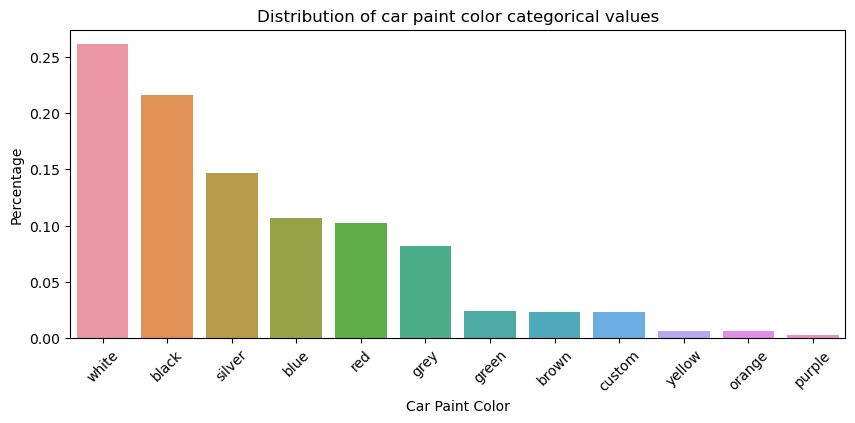

In [27]:
#Visualization for Categorical value distribution
paint_color_df = pd.DataFrame(cars_df["paint_color"].value_counts()/cars_df["paint_color"].count()).reset_index()

plt.figure(figsize=(10,4))
fig = sns.barplot(data=paint_color_df, x="paint_color", y="count")
plt.title("Distribution of car paint color categorical values")
plt.xlabel("Car Paint Color")
plt.ylabel("Percentage")
plt.xticks(rotation=45)
plt.show()

### Drive 
This is a categorial column. Fill up NaN Values of random choice using their original probability.

In [29]:

# Find existing distribution of "drive" categorical values
drive_df=pd.DataFrame(cars_df["drive"].value_counts()/cars_df["drive"].count()).reset_index()

#Function to fill null values for for paint_color column
def replaceDriveNaN(row):
    if pd.isna(row["drive"]):
        return np.random.choice(drive_df["drive"].tolist(), p=drive_df["count"].tolist())

    return row["drive"]

#Apply the function to fill na values
cars_df["drive"] = cars_df.apply(replaceDriveNaN, axis=1)    

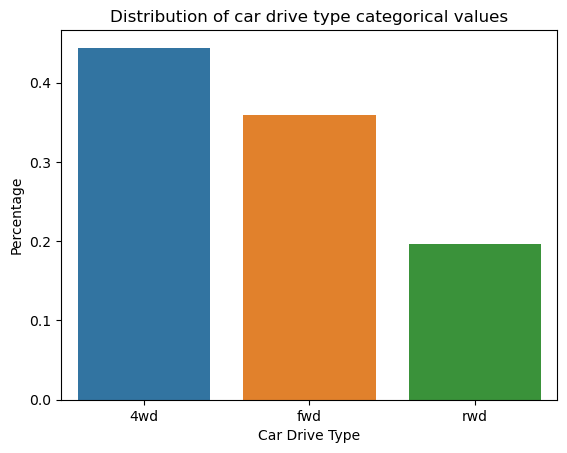

In [30]:
#Visualization for Categorical value distribution
drive_df = pd.DataFrame(cars_df["drive"].value_counts()/cars_df["drive"].count()).reset_index()
fig = sns.barplot(data=drive_df, x="drive", y="count")
plt.title("Distribution of car drive type categorical values")
plt.xlabel("Car Drive Type")
plt.ylabel("Percentage")
plt.show()

### Type 
This is a categorial column. Fill up NaN Values of random choice using their original probability.

In [32]:

# Find existing distribution of "drive" categorical values
type_df=pd.DataFrame(cars_df["type"].value_counts()/cars_df["type"].count()).reset_index()

#Function to fill null values for for paint_color column
def replaceTypeNaN(row):
    if pd.isna(row["type"]):
        return np.random.choice(type_df["type"].tolist(), p=type_df["count"].tolist())

    return row["type"]

#Apply the function to fill na values
cars_df["type"] = cars_df.apply(replaceTypeNaN, axis=1)    

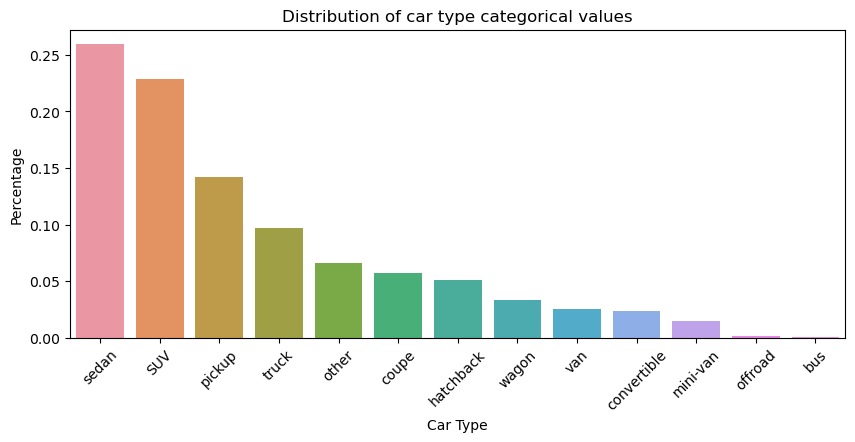

In [33]:
#Visualization for Categorical value distribution
type_df = pd.DataFrame(cars_df["type"].value_counts()/cars_df["type"].count()).reset_index()

plt.figure(figsize=(10,4))
fig = sns.barplot(data=type_df, x="type", y="count")
plt.title("Distribution of car type categorical values")
plt.xlabel("Car Type")
plt.ylabel("Percentage")
plt.xticks(rotation=45)
plt.show()

### Condition
This is a categorial column. There are ~120k null entries for this column. This being a critical features we can handle in couple of ways
1. Drop all null entries - drawback with option is we are going to loose a lot of data
2. Logically fill up null entries - one option is to calculate the mean price for each categorical value and compare with price

I'm going with logically filling up null entries.

In [35]:
#Create a dictionary of condition and average price
temp_df = cars_df.groupby("condition")[["price"]].mean().reset_index()
con_price = dict(zip(temp_df["condition"],round(temp_df["price"])))

#Function with logic to populate for null condition values.
def replaceConditionNaN(row):
    if pd.isna(row["condition"]):
        if(row["price"] > con_price.get("new")):
            return "new"
        if(row["price"] > con_price.get("like new")):
            return "like new"
        if(row["price"] > con_price.get("excellent")):
            return "excellent"
        if(row["price"] > con_price.get("good")):
            return "good"
        if(row["price"] > con_price.get("fair")):
            return "fair"
        else :
            return "salvage"

    return row["condition"]

#Apply the function to fill na values
cars_df["condition"] = cars_df.apply(replaceConditionNaN, axis=1)    

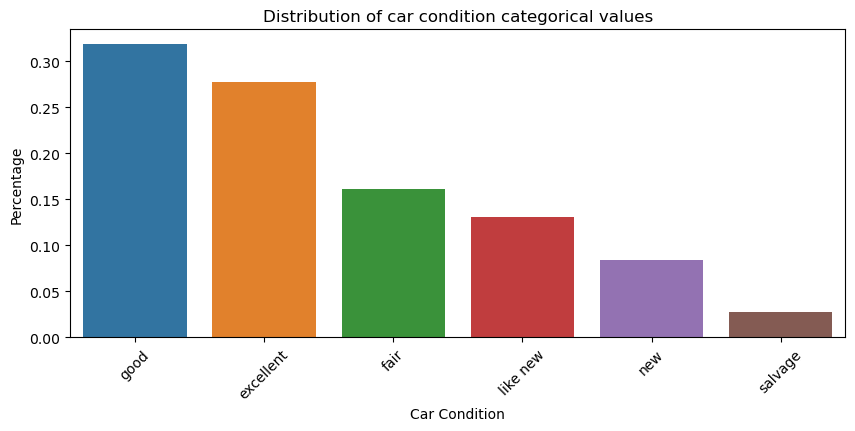

In [36]:
#Visualization for Categorical value distribution
condition_df = pd.DataFrame(cars_df["condition"].value_counts()/cars_df["condition"].count()).reset_index()

plt.figure(figsize=(10,4))
fig = sns.barplot(data=condition_df, x="condition", y="count")
plt.title("Distribution of car condition categorical values")
plt.xlabel("Car Condition")
plt.ylabel("Percentage")
plt.xticks(rotation=45)
plt.show()

### Fuel
This is a categorical column. One of the value is other and it doesn't make sense, so need to transform using custom logic.

In [38]:
#Function with logic to populate for other values.
def replaceFuelOther(row):
    if (row["fuel"] == "other"):
        if(row["manufacturer"] == 'tesla'):
            return "electric"
        if(row["year"] > 2014) | (row["type"] in ['pickup','other','van','convertible','truck']):
            return "gas"
        else:
            return np.random.choice(['gas','hybrid', 'diesel','electric'], p=[0.65,0.2,0.03,0.12])

    return row["fuel"]

#Apply the function to fill other values
cars_df["fuel"] = cars_df.apply(replaceFuelOther, axis=1)  

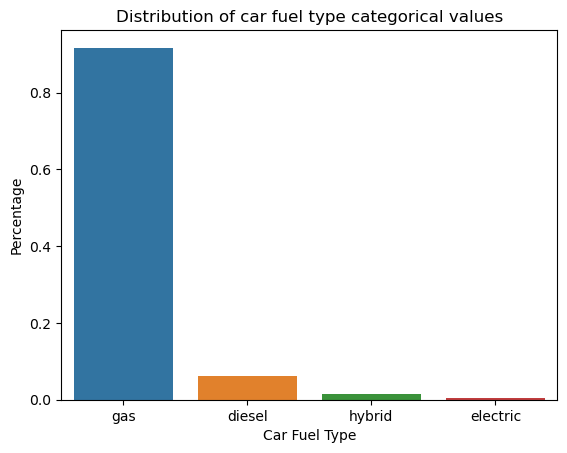

In [39]:
#Visualization for Categorical value distribution
fuel_df = pd.DataFrame(cars_df["fuel"].value_counts()/cars_df["fuel"].count()).reset_index()
fig = sns.barplot(data=fuel_df, x="fuel", y="count")
plt.title("Distribution of car fuel type categorical values")
plt.xlabel("Car Fuel Type")
plt.ylabel("Percentage")
plt.show()

# Modeling

In [41]:
#Make a working copy of dataset
df = cars_df

In [42]:
df.dropna(inplace=True)

### Encoding of categorical columns

We have a few categorical columns which are expected to play major role in modeling, so we are going to replace them with numbers. While can use this mapping while tabulating the analysis report/result.

In [44]:
df = df.replace({"size":{'full-size':1, 'mid-size':2, 'compact':3, 'sub-compact':4}})
df["size"] = pd.to_numeric(df["size"])

df = df.replace({"condition":{"new":1, "like new":2, "excellent":3, "good":4,"fair":5,"salvage":6}})
df["condition"] = pd.to_numeric(df["condition"])

df = df.replace({"fuel":{"gas":1, "diesel":2,"hybrid":3, "electric":4}})
df["fuel"] = pd.to_numeric(df["fuel"])

df = df.replace({"transmission":{"manual":1, "automatic":2,"other":3}})
df["transmission"] = pd.to_numeric(df["transmission"])

df = df.replace({"drive":{"fwd":1, "4wd":2,"rwd":3}})
df["drive"] = pd.to_numeric(df["drive"])

df = df.replace({"title_status":{"clean":1, "rebuilt":2,"lien":3}})
df["title_status"] = pd.to_numeric(df["title_status"])

In [45]:
df.head()

,price,year,manufacturer,condition,fuel,title_status,transmission,drive,size,type,paint_color
27,33590,2014.0,gmc,4,1,1,3,3,3,pickup,white
28,22590,2010.0,chevrolet,4,1,1,3,3,1,pickup,blue
29,39590,2020.0,chevrolet,4,1,1,3,3,1,pickup,red
30,30990,2017.0,toyota,4,1,1,3,1,1,pickup,red
31,15000,2013.0,ford,3,1,1,2,3,1,truck,black


In [46]:
num_cols =["year","condition","fuel","title_status","transmission","drive","size"]
cat_cols = ["manufacturer","type","paint_color"]


In [47]:
# Create Train, test dataset splits
X = df.drop(columns=['price'])
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [48]:
# Defining the column transformer to handle categorical data

preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(), cat_cols),
        ('scaler', StandardScaler(), num_cols)
    ]
)

## Linear Regression Model

Linear Regression Model :




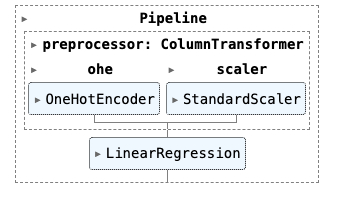



Mean cross_val_scores : nan
MSE of Testing Data : 106968774.29642797
R2 score of Testing Data : 0.5062686341999585


In [50]:
#Define model
linear_model = Pipeline([('preprocessor', preprocessor),
                        ("regressor", LinearRegression())  
                        ])
#Cross Validation
cross_val_scores = cross_val_score(linear_model, X_train, y_train, cv=5, scoring='r2')

#Train the model
linear_model.fit(X_train,y_train)

#Predict on test data
y_pred = linear_model.predict(X_test)

#Evaluate model
print("Linear Regression Model :")
print("\n")
display.display(Image.open("images/linearmodel.png"))

print("\n")
print(f'Mean cross_val_scores : {cross_val_scores.mean()}')
print(f'MSE of Testing Data : {mean_squared_error(y_test, y_pred)}')
print(f'R2 score of Testing Data : {r2_score(y_test, y_pred)}')

In [51]:
#Identify important features
linear_model_pi = permutation_importance(linear_model, X_test, y_test, scoring='neg_mean_squared_error', n_repeats=10, random_state=21)

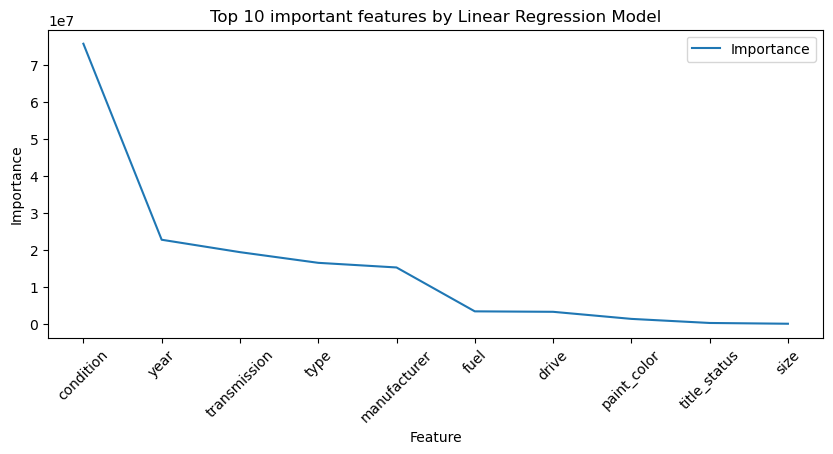

In [52]:
# Create a DataFrame
linear_importance_df = pd.DataFrame({
                    'Feature': X_test.columns,
                    'Importance': linear_model_pi.importances_mean
                    }).sort_values(by='Importance', ascending=False)
linear_importance_df = linear_importance_df.set_index("Feature")

#print(linear_importance_df)
print("\n")

# Generate visualization of importance features
plt.figure(figsize=(10,4))
sns.lineplot(linear_importance_df)
plt.title("Top 10 important features by Linear Regression Model")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation=45) 
plt.show()

## Ridge Model

#### Grid Search to identify hyper parameters

In [55]:
#Using GridSearchCV to identify the best alpha parameter
pipe = Pipeline([('preprocessor', preprocessor),
                        ("model", Ridge())])

param_dict = {"model__alpha":[ 0.01, 0.1, 1.0,10.0,100.0]}
grid = GridSearchCV(estimator=pipe, param_grid=param_dict, scoring="neg_mean_squared_error", cv=5)
grid.fit(X_train, y_train)

print(f' Best Hyper parameter : {grid.best_params_}')

 Best Hyper parameter : {'model__alpha': 0.01}


Ridge Regression Model :




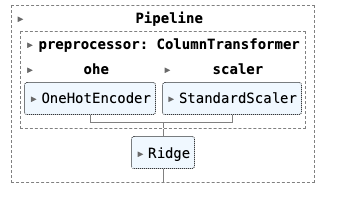



Mean cross_val_scores : nan
MSE of Testing Data : 106948797.8659339
R2 score of Testing Data : 0.5063608385874212


In [56]:
#Define model
ridge_model = Pipeline([('preprocessor', preprocessor),
                        ("model", Ridge(alpha =0.01))  
                        ])

#Cross Validation
ridge_cross_val_scores = cross_val_score(ridge_model, X_train, y_train, cv=5, scoring='r2')

#Train the model
ridge_model.fit(X_train,y_train)

#Predict on test data
y_pred = ridge_model.predict(X_test)

#Evaluate model
print("Ridge Regression Model :")
print("\n")
display.display(Image.open("images/ridge.png"))
print("\n")
print(f'Mean cross_val_scores : {ridge_cross_val_scores.mean()}')
print(f'MSE of Testing Data : {mean_squared_error(y_test, y_pred)}')
print(f'R2 score of Testing Data : {r2_score(y_test, y_pred)}')


In [57]:
#Identify important features
ridge_pi = permutation_importance(ridge_model, X_test, y_test, scoring='neg_mean_squared_error', n_repeats=10, random_state=21)

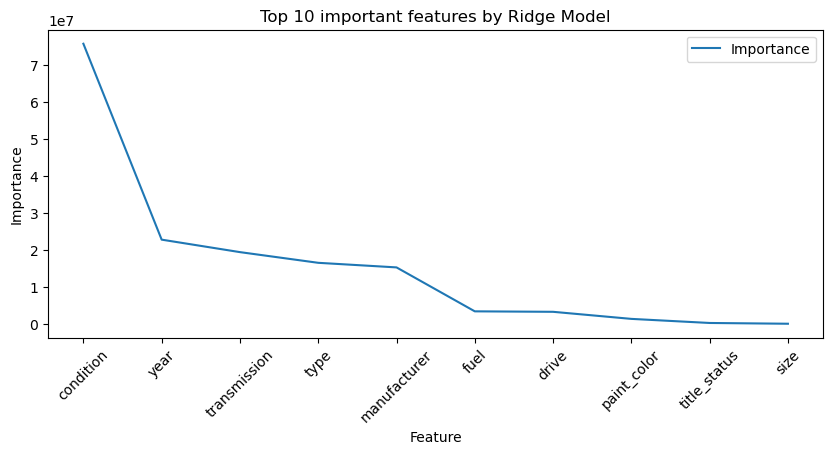

In [58]:
# Create a DataFrame
ridge_importance_df = pd.DataFrame({
                    'Feature': X_test.columns,
                    'Importance': ridge_pi.importances_mean
                    }).sort_values(by='Importance', ascending=False)
ridge_importance_df = ridge_importance_df.set_index("Feature")
#print(ridge_importance_df)
print("\n")
# Generate visualization of importance features
plt.figure(figsize=(10,4))
sns.lineplot(ridge_importance_df)
plt.title("Top 10 important features by Ridge Model")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation=45) 
plt.show()



## Lasso Model

Lasso Regression Model :




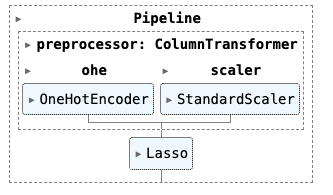



Mean cross_val_scores : nan
MSE of Testing Data : 107033784.58935182
R2 score of Testing Data : 0.505968568868487


In [60]:
#Define model
lasso_model = Pipeline([('preprocessor', preprocessor),
                        ("model", Lasso())  
                        ])

#Cross Validation
lasso_cross_val_scores = cross_val_score(lasso_model, X_train, y_train, cv=5, scoring='r2')

#Train the model
lasso_model.fit(X_train,y_train)

#Predict on test data
y_pred = lasso_model.predict(X_test)

#Evaluate model
print("Lasso Regression Model :")

print("\n")
display.display(Image.open("images/lasso.png"))
print("\n")

print(f'Mean cross_val_scores : {lasso_cross_val_scores.mean()}')
print(f'MSE of Testing Data : {mean_squared_error(y_test, y_pred)}')
print(f'R2 score of Testing Data : {r2_score(y_test, y_pred)}')

In [61]:
#Identify important features
lasso_pi = permutation_importance(lasso_model, X_test, y_test, scoring='neg_mean_squared_error', n_repeats=10, random_state=21)

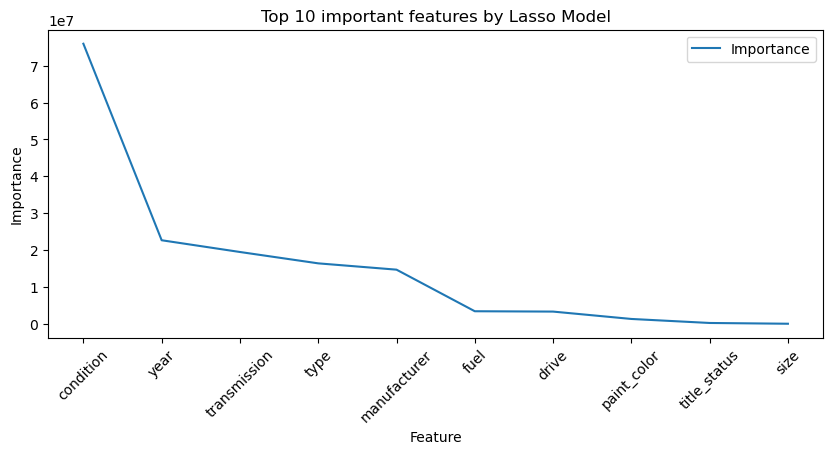

In [62]:
# Create a DataFrame
lasso_importance_df = pd.DataFrame({
                    'Feature': X_test.columns,
                    'Importance': lasso_pi.importances_mean
                    }).sort_values(by='Importance', ascending=False)
lasso_importance_df = lasso_importance_df.set_index("Feature")[0:10]

# Generate visualization of importance features
plt.figure(figsize=(10,4))
sns.lineplot(lasso_importance_df)
plt.title("Top 10 important features by Lasso Model")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation=45) 
plt.show()

## Further analysis and modelling on top features

In [64]:
#Create dataframe with price and top features
top4_df= cars_df[["price","condition","type","year","manufacturer"]]

In [65]:
top4_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 351222 entries, 27 to 426879
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         351222 non-null  int64  
 1   condition     351222 non-null  object 
 2   type          351222 non-null  object 
 3   year          351222 non-null  float64
 4   manufacturer  351222 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 16.1+ MB


In [66]:
#Encoder for categorical columns
ohe = OneHotEncoder(sparse=False, handle_unknown="error")

In [67]:
#Create encoded dataframe for condition, type feature
top4_encoded_df = top4_df.join(pd.DataFrame(ohe.fit_transform(top4_df[["condition","type"]]), columns=ohe.get_feature_names_out()))\
                    .drop(columns=["condition","type","year","manufacturer"]).dropna()
top4_encoded_df.head(5)

,price,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,type_SUV,type_bus,type_convertible,type_coupe,type_hatchback,type_mini-van,type_offroad,type_other,type_pickup,type_sedan,type_truck,type_van,type_wagon
27,33590,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
28,22590,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
29,39590,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
30,30990,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
31,15000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
#Split dataset for train and test
T4X=top4_encoded_df.drop(columns=["price"])
T4X_train, T4X_test, t4y_train, t4y_test = train_test_split(T4X, top4_encoded_df["price"], test_size=0.2, random_state=21)

#Build and fit ridge model
t4_rmodel = Pipeline([("scaler", StandardScaler()),("model", Ridge(alpha=0.01))]).fit(T4X_train, t4y_train)

#Predict on test data
t4y_pred = t4_rmodel.predict(T4X_test)

#Evaluate model
print(f'MSE of Testing Data : {mean_squared_error(t4y_test, t4y_pred)}')
print(f'R2 score of Testing Data : {r2_score(t4y_test, t4y_pred)}')


MSE of Testing Data : 214482717.60367095
R2 score of Testing Data : 0.00011483751827490174


In [69]:
#Create encoded dataframe for year feature
year_encoded_df = top4_df.join(pd.DataFrame(ohe.fit_transform(top4_df[["year"]]), columns=ohe.get_feature_names_out()))\
                    .drop(columns=["year","condition","type","manufacturer"]).dropna()
year_encoded_df.head(5)

,price,year_1900.0,year_1905.0,year_1913.0,year_1915.0,year_1918.0,year_1921.0,year_1922.0,year_1923.0,year_1924.0,...,year_2013.0,year_2014.0,year_2015.0,year_2016.0,year_2017.0,year_2018.0,year_2019.0,year_2020.0,year_2021.0,year_2022.0
27,33590,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,22590,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
29,39590,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
30,30990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31,15000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
#Split dataset for train and test 
YX=year_encoded_df.drop(columns=["price"])
YX_train, YX_test, yy_train, yy_test = train_test_split(YX, year_encoded_df["price"], test_size=0.3, random_state=21)

#Build and fit ridge model
y_rmodel = Pipeline([("model", Ridge(alpha=1.0))]).fit(YX_train, yy_train)


#Predict on test data
yy_pred = y_rmodel.predict(YX_test)

#Evaluate model
print(f'MSE of Testing Data : {mean_squared_error(yy_test, yy_pred)}')
print(f'R2 of Testing Data : {r2_score(yy_test, yy_pred)}')



MSE of Testing Data : 213278184.73917148
R2 of Testing Data : -0.00036142338718647693


In [71]:
#Create encoded dataframe for manufacturer feature
manu_encoded_df = top4_df[["price"]].join(pd.DataFrame(ohe.fit_transform(top4_df[["manufacturer"]]), columns=ohe.get_feature_names_out()))\
                    .dropna()
manu_encoded_df.head(5)

,price,manufacturer_acura,manufacturer_alfa-romeo,manufacturer_aston-martin,manufacturer_audi,manufacturer_bmw,manufacturer_buick,manufacturer_cadillac,manufacturer_chevrolet,manufacturer_chrysler,...,manufacturer_pontiac,manufacturer_porsche,manufacturer_ram,manufacturer_rover,manufacturer_saturn,manufacturer_subaru,manufacturer_tesla,manufacturer_toyota,manufacturer_volkswagen,manufacturer_volvo
27,33590,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,22590,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29,39590,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,30990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31,15000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
#Split dataset for train and test
MX=manu_encoded_df.drop(columns=["price"])
MX_train, MX_test, my_train, my_test = train_test_split(MX, manu_encoded_df["price"], test_size=0.3, random_state=21)

#Build and fit ridge model
m_rmodel = Pipeline([("model", Ridge(alpha=1.0))]).fit(MX_train, my_train)

#Predict on test data
my_pred = m_rmodel.predict(MX_test)

#Evaluate model
print(f'MSE of Testing Data : {mean_squared_error(my_test, my_pred)}')
print(f'R2 of Testing Data : {r2_score(my_test, my_pred)}')


MSE of Testing Data : 213211536.68864426
R2 of Testing Data : -4.8816925475758666e-05
